In [36]:
import pandas as pd
import numpy as np
import os
import shapely
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd

print("done")


done


In [37]:
airqual_may=pd.read_csv("D:\\Data projects\\Air pollution Madrid\\data\\air data\\Calidad aire 2024\\pollution\\may_mo24.csv", sep=";")
airqual_abr=pd.read_csv("D:\\Data projects\\Air pollution Madrid\\data\\air data\\Calidad aire 2024\\pollution\\abr_mo24.csv", sep=";")

In [38]:
# Function to extract the numbers before the first underscore
def extract_numbers(value):
    return value.split('_')[0]

# List of files to process with full paths
files = [
    r'D:\\Data projects\\Air pollution Madrid\\data\\air data\\Calidad aire 2024\\pollution\\may_mo24.csv',
    r'D:\\Data projects\\Air pollution Madrid\\data\\air data\\Calidad aire 2024\\pollution\\abr_mo24.csv'
]

for file in files:
    # Read the CSV file
    df = pd.read_csv(file, sep=";")
    
    # Check if the column 'PUNTO_MUESTREO' exists in the DataFrame
    if 'PUNTO_MUESTREO' in df.columns:
        # Create the new column and fill it with the extracted values
        df['ID_EST'] = df['PUNTO_MUESTREO'].apply(extract_numbers)
        
        # Reorder columns to make the new column the first one
        columns_order = ['ID_EST'] + [col for col in df.columns if col != 'ID_EST']
        df = df[columns_order]
        #drop unnecessary cols
        df.drop(df.columns[[1, 2, 3]], axis=1, inplace=True)
        # Find columns that start with 'V'
        columns_with_v = [col for col in df.columns if col.startswith('V')]

        # Keep rows where any of these columns have the value 'V'
        # Variables not assigned a V correspond to not valid measurements
        for col in columns_with_v:
            df = df[df[col] == 'V']

        # Drop all validation columns 
        df = df.loc[:, ~df.columns.str.startswith('V')]
        # Reshape the DataFrame to have hourly data in rows
        df_melted = df.melt(id_vars=['ID_EST', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA'],
                            var_name='HOUR', value_name='VALUE')
        
        # Extract the hour from the 'HOUR' column
        df_melted['HOUR'] = df_melted['HOUR'].str.extract('(\d+)', expand=False).astype(int)
        
        # Sort the DataFrame by ID_EST, MAGNITUD, and timestamp
        df_melted = df_melted.sort_values(by=['ID_EST', 'MAGNITUD', 'ANO', 'MES', 'DIA', 'HOUR'])
        # Save the modified DataFrame to a new CSV file
        output_file = file.replace('.csv', '_modified.csv')
        df_melted.to_csv(output_file, index=False)


In [39]:
#concatenate the modified files 
may = pd.read_csv('D:\\Data projects\\Air pollution Madrid\\data\\air data\\Calidad aire 2024\\pollution\\may_mo24_modified.csv',sep=",")
apr = pd.read_csv('D:\\Data projects\\Air pollution Madrid\\data\\air data\\Calidad aire 2024\\pollution\\abr_mo24_modified.csv',sep=",")
air_data = pd.concat([apr, may], ignore_index=True)


In [40]:
# Now we merge the air_data with the coordinates of each station
# Load the CSV file
file_path = "D:\\Data projects\\Air pollution Madrid\\data\\locations\\air_locations_modified.csv"
locations_df = pd.read_csv(file_path, sep=",")


# Convert the ID_EST column to int to match the ID column in locations_df
air_data['ID_EST'] = air_data['ID_EST'].astype(int)

# Ensure the ID column in locations_df is also of type int (it usually should be)
locations_df['ID'] = locations_df['ID'].astype(int)

# Merge the DataFrames on the corrected ID columns
merged_df = pd.merge(air_data, locations_df, left_on='ID_EST', right_on='ID', how='left')

print("This is the resulting dataset")
merged_df

This is the resulting dataset


,ID_EST,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,HOUR,VALUE,ID,LATITUD,LONGITUD
0,28079004,1,28079004_1_38,2024,4,1,1,1.0,28079004,40.423882,-3.712257
1,28079004,1,28079004_1_38,2024,4,1,2,1.0,28079004,40.423882,-3.712257
2,28079004,1,28079004_1_38,2024,4,1,3,1.0,28079004,40.423882,-3.712257
3,28079004,1,28079004_1_38,2024,4,1,4,1.0,28079004,40.423882,-3.712257
4,28079004,1,28079004_1_38,2024,4,1,5,1.0,28079004,40.423882,-3.712257
...,...,...,...,...,...,...,...,...,...,...,...
161395,28079060,14,28079060_14_6,2024,5,31,20,105.0,28079060,40.500548,-3.689731
161396,28079060,14,28079060_14_6,2024,5,31,21,100.0,28079060,40.500548,-3.689731
161397,28079060,14,28079060_14_6,2024,5,31,22,95.0,28079060,40.500548,-3.689731
161398,28079060,14,28079060_14_6,2024,5,31,23,90.0,28079060,40.500548,-3.689731


In [41]:
# Drop rows with NaN values in MAGNITUD column
merged_df.dropna(subset=['MAGNITUD'], inplace=True)

NAS = merged_df["MAGNITUD"].isnull().sum()
print(f"Number of NaN values in column 'MAGNITUD': {NAS}")


Number of NaN values in column 'MAGNITUD': 0


In [42]:
merged_df['MAGNITUD'] = merged_df['MAGNITUD'].astype(int)

# Mapping of MAGNITUD codes to parameter names
magnitude_mapping = {
    1 : "SO2",
    6 : "CO",
    7 : "NO", 
    8 : "NO2",
    9 : "PM2.5",
    10 : "PM10",
    12 : "NOX",
    14 : "O3",
    20 : "TOL", 
    30 : "BEN", 
    35 : "EBE",
    37 : "MXY",
    38 : "PXY", 
    39 : "OXY", 
    42 : "TCH",
    43 : "CH4",
    44 : "NMHC",
    431 : "MPX"
    }

# Replace MAGNITUD codes with their respective names
merged_df['MAGNITUD'] = merged_df['MAGNITUD'].map(magnitude_mapping)

# Pivot the table
airqual = merged_df.pivot_table(index=['ID_EST', 'ANO', 'MES', 'DIA', 'HOUR', 'LATITUD', 'LONGITUD'],
                                    columns='MAGNITUD',
                                    values='VALUE', aggfunc='mean').reset_index()

# Flatten the columns
airqual.columns.name = None

print("The airquality dataset is ready:")
airqual

The airquality dataset is ready:


,ID_EST,ANO,MES,DIA,HOUR,LATITUD,LONGITUD,BEN,CO,EBE,NO,NO2,NOX,O3,PM10,PM2.5,SO2,TOL
0,28079004,2024,4,1,1,40.423882,-3.712257,NaN,0.3,NaN,1.0,9.0,11.0,NaN,NaN,NaN,1.0,NaN
1,28079004,2024,4,1,2,40.423882,-3.712257,NaN,0.3,NaN,1.0,8.0,10.0,NaN,NaN,NaN,1.0,NaN
2,28079004,2024,4,1,3,40.423882,-3.712257,NaN,0.3,NaN,1.0,7.0,9.0,NaN,NaN,NaN,1.0,NaN
3,28079004,2024,4,1,4,40.423882,-3.712257,NaN,0.3,NaN,1.0,8.0,9.0,NaN,NaN,NaN,1.0,NaN
4,28079004,2024,4,1,5,40.423882,-3.712257,NaN,0.3,NaN,1.0,8.0,9.0,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31891,28079060,2024,5,31,20,40.500548,-3.689731,NaN,NaN,NaN,1.0,7.0,9.0,105.0,12.0,NaN,NaN,NaN
31892,28079060,2024,5,31,21,40.500548,-3.689731,NaN,NaN,NaN,1.0,9.0,11.0,100.0,13.0,NaN,NaN,NaN
31893,28079060,2024,5,31,22,40.500548,-3.689731,NaN,NaN,NaN,1.0,10.0,11.0,95.0,13.0,NaN,NaN,NaN
31894,28079060,2024,5,31,23,40.500548,-3.689731,NaN,NaN,NaN,1.0,11.0,12.0,90.0,14.0,NaN,NaN,NaN


Save the dataset for further use

In [43]:
# Specify the directory and filename to save the combined DataFrame
output_directory = r"D:\\Data projects\\Air pollution Madrid\\data\\air data\\Calidad aire 2024\\pollution"
output_filename = 'air_geolocated.csv'
output_file = os.path.join(output_directory, output_filename)

# Save the combined DataFrame to a new CSV file
airqual.to_csv(output_file, index=False)

### Data viz 
Check data behavior

In [44]:
stations = pd.DataFrame(airqual["ID_EST"].unique(), columns = ["Air quality Station ID"])
stations


,Air quality Station ID
0,28079004
1,28079008
2,28079011
3,28079016
4,28079017
5,28079018
6,28079024
7,28079027
8,28079035
9,28079036


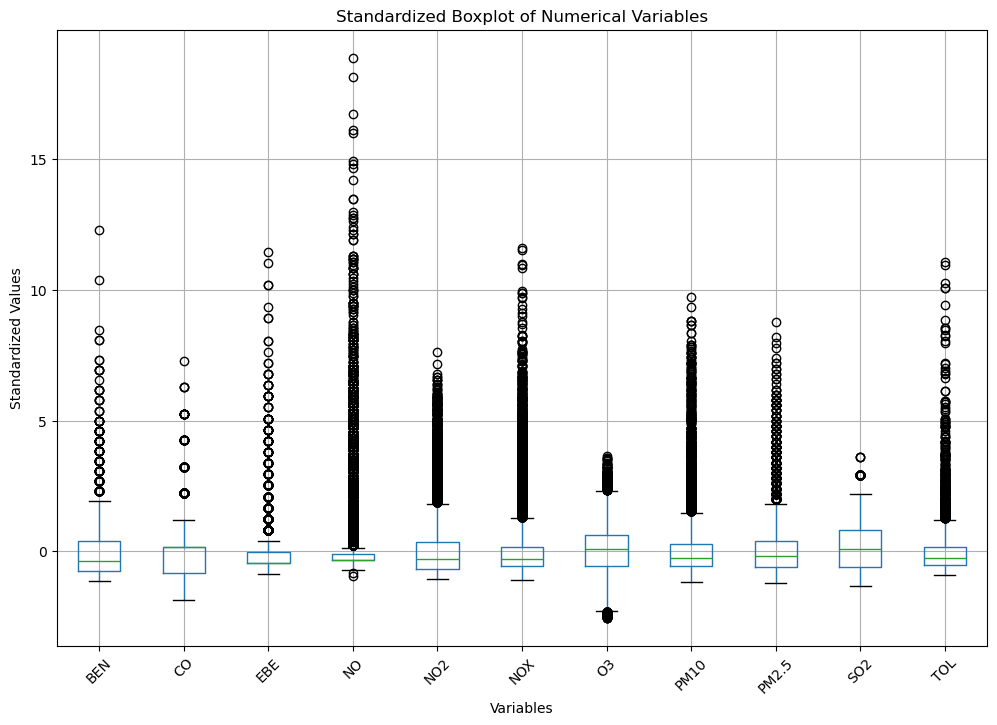

In [45]:
from sklearn.preprocessing import StandardScaler

# identify numerical cols except ID
numerical_cols = airqual.select_dtypes(include='number').columns[7:]


# Standardize the data for boxplot visualization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(airqual[numerical_cols])
standardized_df = pd.DataFrame(standardized_data, columns=numerical_cols)


# Create a boxplot for the standardized data
plt.figure(figsize=(12, 8))
standardized_df.boxplot()
plt.title('Standardized Boxplot of Numerical Variables')
plt.xlabel('Variables')
plt.ylabel('Standardized Values')
plt.xticks(rotation=45)
plt.show()

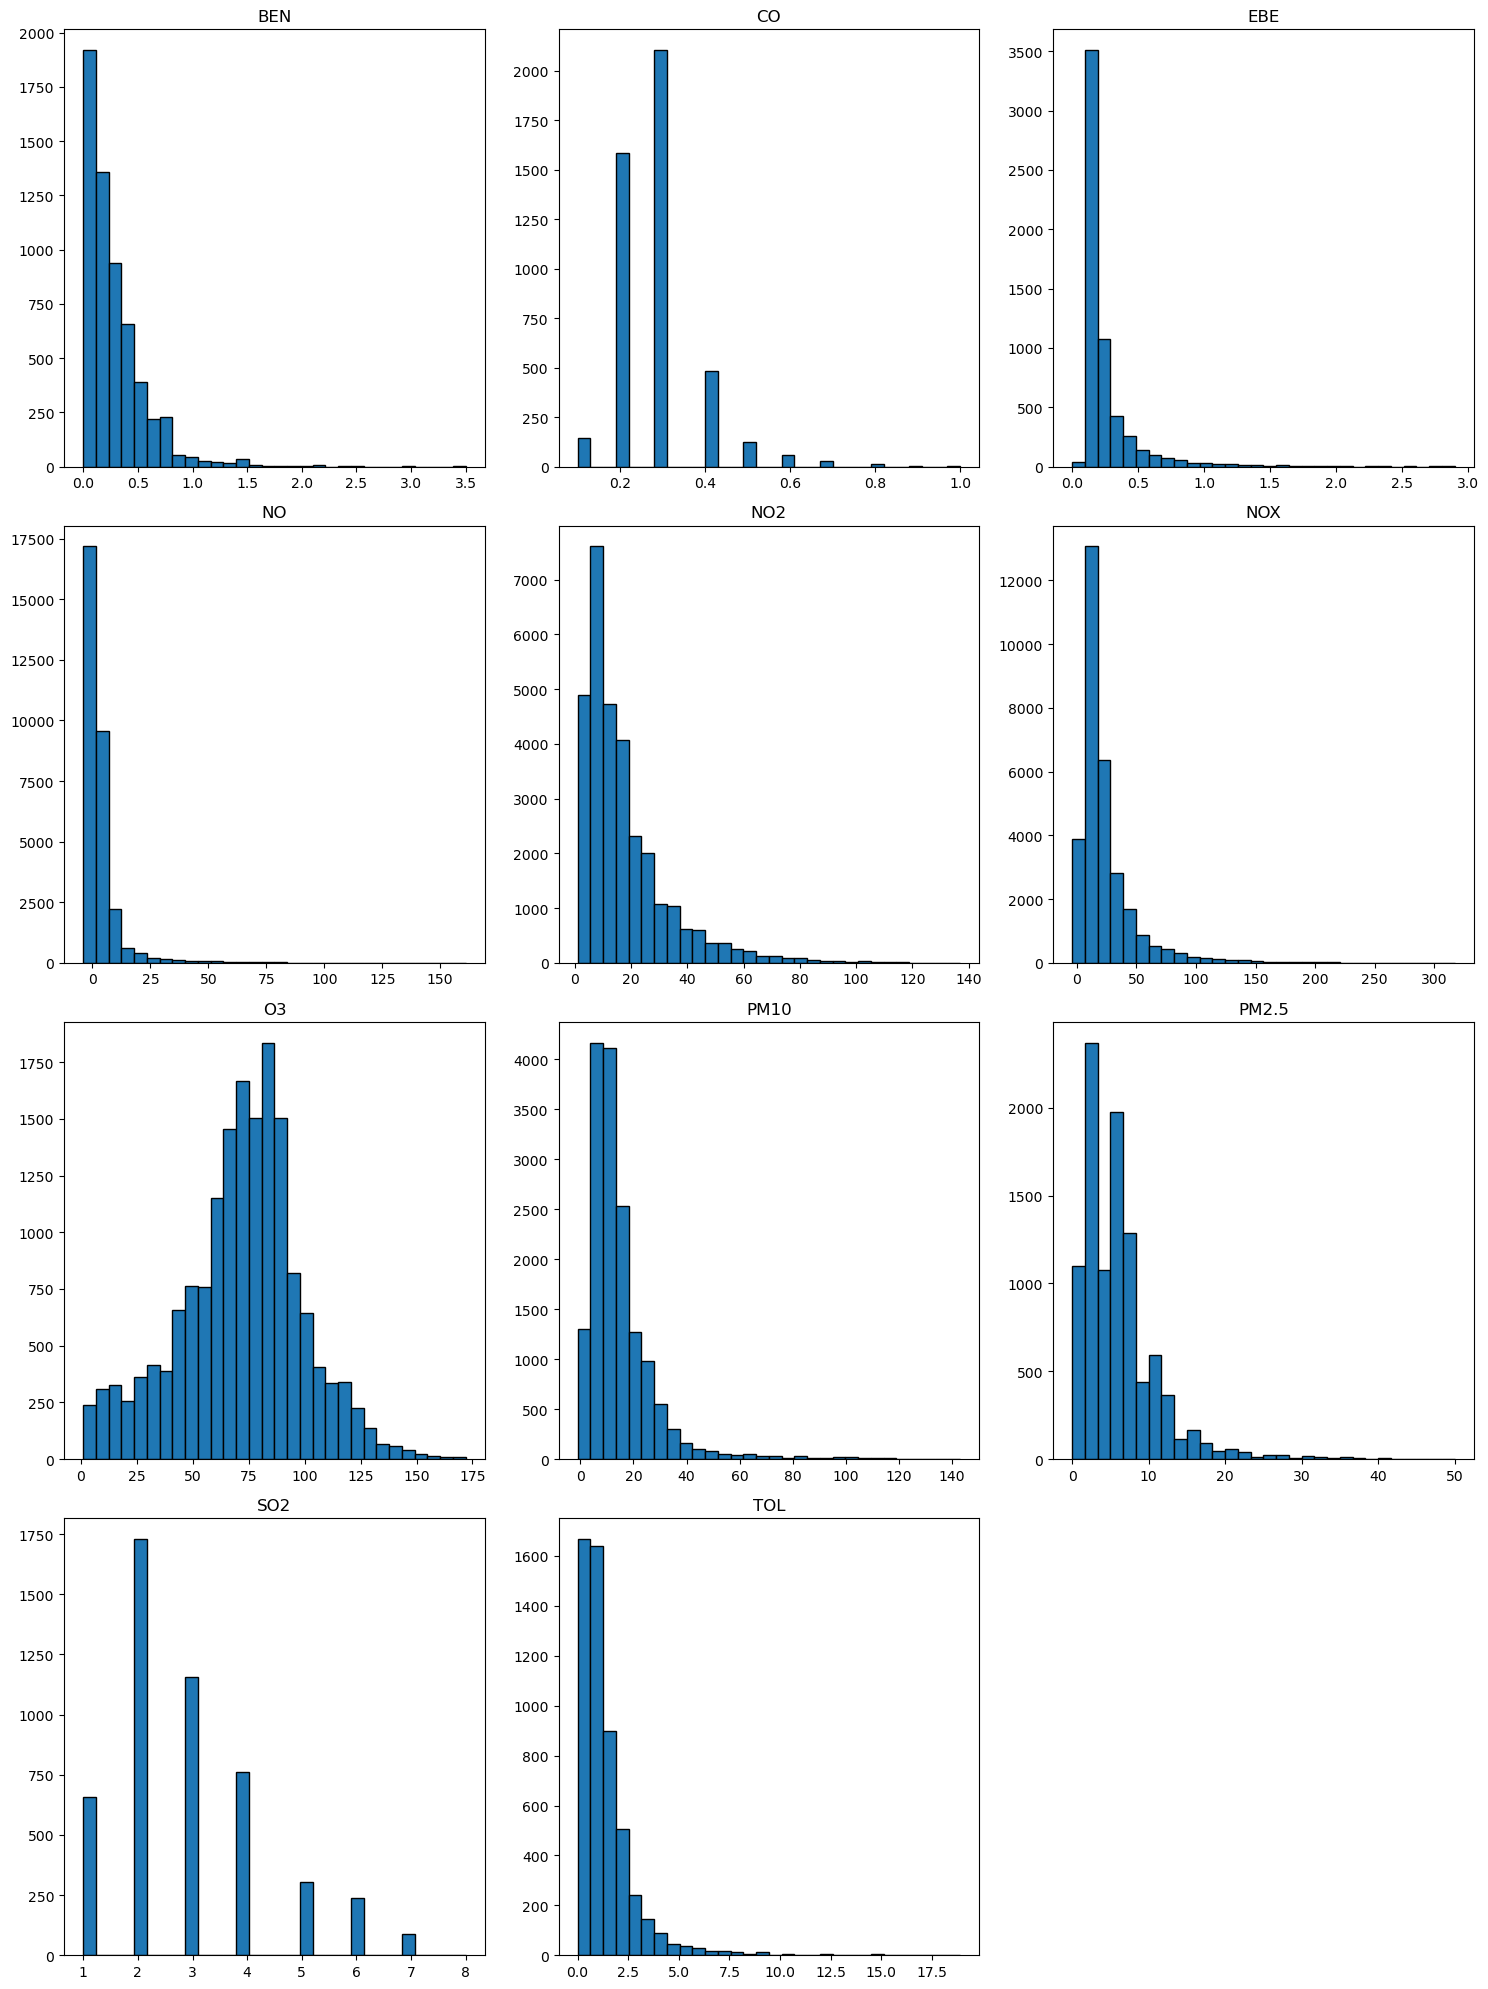

In [46]:
# Select numerical columns
numerical_cols = airqual.select_dtypes(include='number').columns[7:]

# Determine the number of rows needed
num_cols = 3
num_rows = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each numerical column
for i, col in enumerate(numerical_cols):
    axes[i].hist(airqual[col].dropna(), bins=30, edgecolor='k')
    axes[i].set_title(col)


# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
# Adjust layout
plt.tight_layout()
plt.show()